In [1]:
# Install Necessary Libraries
!pip install tensorflow[and-cuda] pandas numpy matplotlib seaborn pillow scipy scikit-learn --break-system-packages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 333.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 182.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 117.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Import Required Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from PIL import Image


2024-11-01 16:19:59.348605: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 16:19:59.364646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730477999.382636    6165 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730477999.388133    6165 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 16:19:59.406776: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Check if TensorFlow is using the GPU
!nvidia-smi
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Fri Nov  1 16:20:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:D2:00.0 Off |                    0 |
|  0%   36C    P0             76W /  300W |   43887MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Example Data Generator for Training and Validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Adjust target_size to match your image dimensions
train_generator = train_datagen.flow_from_directory(
    'face-expression-recognition-dataset/images/train/',
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for multiclass classification
)

validation_generator = validation_datagen.flow_from_directory(
    'face-expression-recognition-dataset/images/validation/',
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [6]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),  # Adjust input shape to (48, 48, 3)
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # Assuming you have 7 classes
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1730478051.226895    6165 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1026 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:d2:00.0, compute capability: 8.6


In [7]:
# Define callbacks
# Save the model after every epoch if it is the best seen so far
checkpoint = ModelCheckpoint(
    'models/r1_best_model.keras',        # File path to save the best model
    monitor='val_loss',        # Monitors the validation loss
    save_best_only=True,       # Saves only the best model
    mode='min',                # Mode is 'min' because lower validation loss is better
    verbose=1                  # Verbosity mode
)

# Reduce learning rate when a metric has stopped improving
lr_adjustment = ReduceLROnPlateau(
    monitor='val_loss',    # Monitors the validation loss
    factor=0.5,            # Factor by which the learning rate will be reduced
    patience=3,            # Number of epochs with no improvement before reducing learning rate
    min_lr=1e-6,           # Minimum learning rate
    verbose=1              # Verbosity mode
)

# Stop training when a monitored metric has stopped improving
early_stop = EarlyStopping(
    monitor='val_loss',    # Monitors the validation loss
    patience=5,            # Number of epochs with no improvement before stopping training
    verbose=1,             # Verbosity mode
    restore_best_weights=True  # Restores model weights from the epoch with the best value
)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,855 (4.36 MB)

 Trainable params: 1,142,855 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the Model with Callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[checkpoint, lr_adjustment, early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1730478065.635796    6718 service.cc:148] XLA service 0x70640c003f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730478065.635864    6718 service.cc:156]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-11-01 16:21:05.737834: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730478065.929476    6718 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/901 ━━━━━━━━━━━━━━━━━━━━ 1:07 76ms/step - accuracy: 0.1719 - loss: 1.9493

I0000 00:00:1730478068.135285    6718 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.2397 - loss: 1.8246
Epoch 1: val_loss improved from inf to 1.71117, saving model to models/r1_best_model.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 155s 168ms/step - accuracy: 0.2397 - loss: 1.8245 - val_accuracy: 0.3094 - val_loss: 1.7112 - learning_rate: 0.0010
Epoch 2/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2985 - loss: 1.7154
Epoch 2: val_loss improved from 1.71117 to 1.53190, saving model to models/r1_best_model.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 109s 121ms/step - accuracy: 0.2986 - loss: 1.7154 - val_accuracy: 0.4009 - val_loss: 1.5319 - learning_rate: 0.0010
Epoch 3/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3765 - loss: 1.5908
Epoch 3: val_loss improved from 1.53190 to 1.40381, saving model to models/r1_best_model.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 120s 134ms/step - accuracy: 0.3765 - loss: 1.5907 - val_accuracy: 0.4699 - val_loss: 1.4038 - learning_rate: 0.0010
Epoch 4/30
901/901 ━━━━━━━━━━━━

In [9]:
# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,428,567 (13.08 MB)

 Trainable params: 1,142,855 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,285,712 (8.72 MB)

In [16]:
# classification report

# Generate true labels and predictions for the validation set
y_true = []
y_pred = []

# Compute predictions for each batch in the validation set
for _ in range(validation_steps):
    x_batch, y_batch = next(validation_generator)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))

# Print the classification report
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

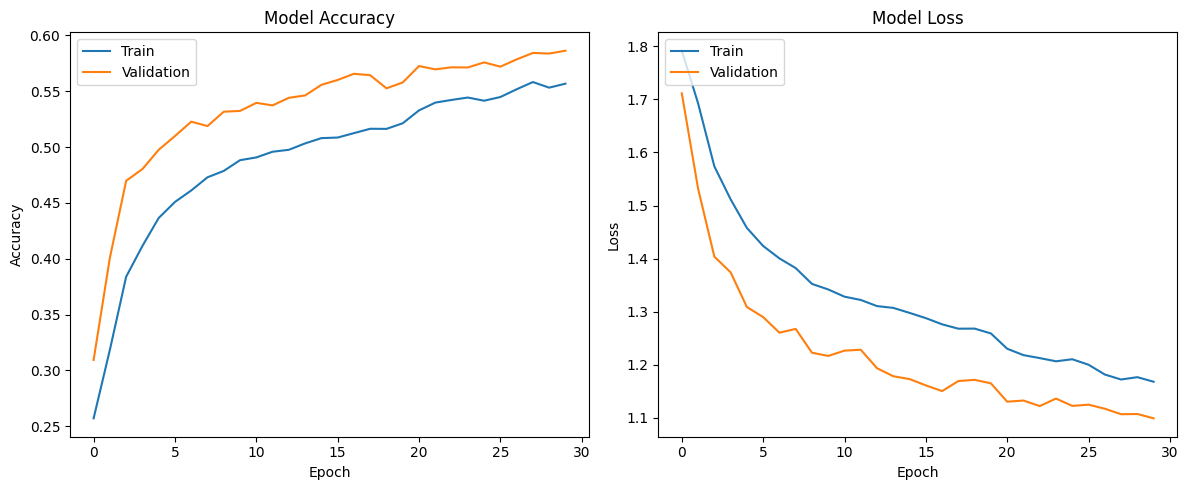

In [11]:
# plot training history
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

<Figure size 800x600 with 0 Axes>

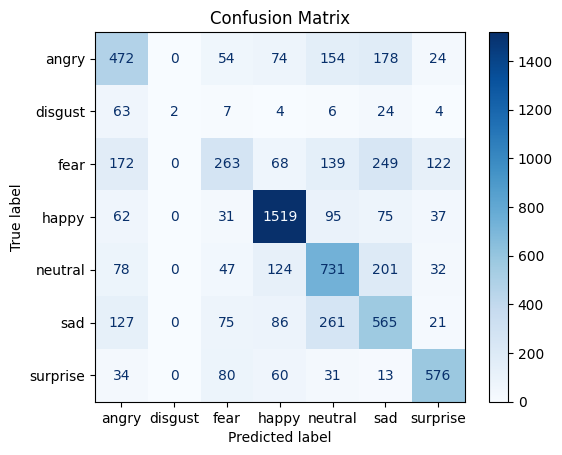

In [15]:
# confusion matrix

# Get the true labels and predictions for the validation set
validation_steps = validation_generator.samples // validation_generator.batch_size
y_true = []
y_pred = []

for _ in range(validation_steps):
    x_batch, y_batch = next(validation_generator)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


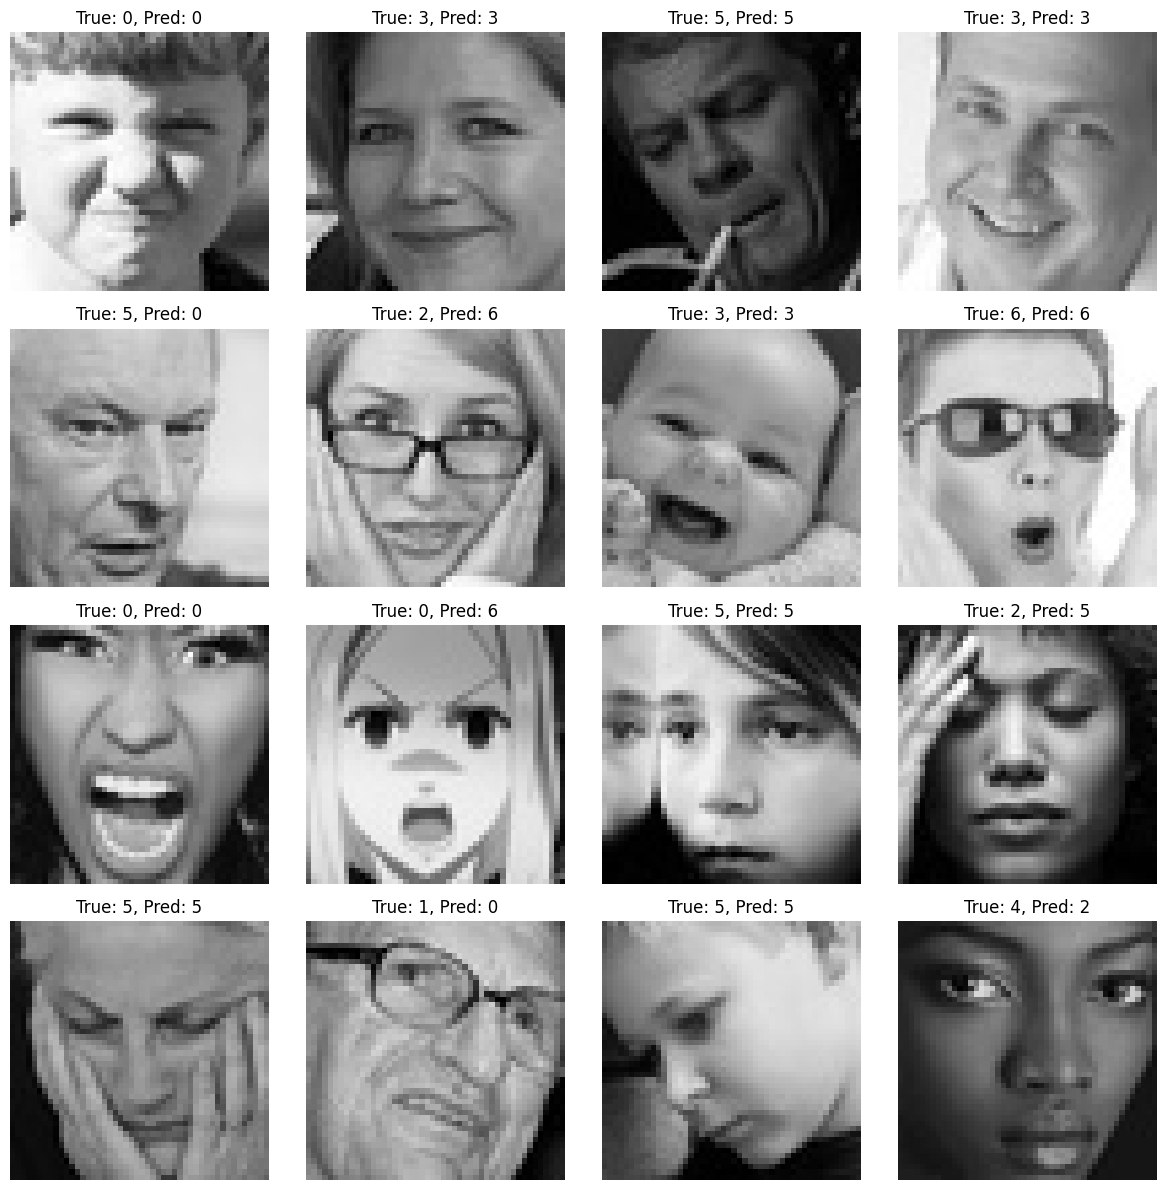

In [17]:
# test model

# Generate a batch of images and labels from the validation generator
x_batch, y_batch = next(validation_generator)

# Select 16 random indices from the batch
random_indices = random.sample(range(len(x_batch)), 16)

# Plot 16 random images with their predicted and true labels
plt.figure(figsize=(12, 12))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(4, 4, i + 1)
    img = x_batch[idx]
    true_label = np.argmax(y_batch[idx])
    prediction = model.predict(img[np.newaxis, ...])
    predicted_label = np.argmax(prediction)

    plt.imshow(img)
    plt.title(f'True: {true_label}, Pred: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [14]:
# Save the Model
model.save('models/r1_expression_classification_model.keras')
print("saved done")

saved done
